# Testing new interpolators for the shear operation

The shear operation in GalFlow works by applying a perspective transform on the coordinate grid of a sampling of the image. We use the tensorflow addons custom ops resampler to implement this. 

However, tfa only comes with standard bilinear interpolation. This is not enough not only because of the interpolation precision, but also because at pixel locations, the bilinear interpolation is not differentiable. As such, we have been working to enhance tfa with new interpolation kernels. 

This notebook is a test of tfa with these new interpolators. The currently available kernels are: "bilinear", "keyscubic", and "bernsteinquintic" (Bernstein & Gruen, 2014).

Original code and idea by @EiffL

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from tensorflow_addons.image import resampler
from scipy.misc import face
import numdifftools
import tensorflow as tf

from numpy.testing import assert_allclose


def facer(interpolant, warp_tf):
  image = face(gray=True)[-512:-512+128,-512:-512+128].astype('float32')
  image_tf = tf.convert_to_tensor(image.reshape([1,128,128, 1]))
  #define a shift
  shift = tf.zeros([1,2])

  #calculate derivatives via tf.GradientTape
  with tf.GradientTape() as tape:
      tape.watch(shift)
      ws = tf.reshape(shift,[1,1,1,2]) + warp_tf
      o = resampler(image_tf, ws, interpolant)
  autodiff_jacobian = tape.batch_jacobian(o, shift) 

  #calculate derivatives via numdifftools
  def fn(shift):
      shift = tf.convert_to_tensor(shift.astype('float32'))
      ws = tf.reshape(shift,[1,1,1,2]) + warp_tf
      o = resampler(image_tf, ws, interpolant)
      return o.numpy().flatten()

  numdiff_jacobian = numdifftools.Jacobian(fn, order=4, step=0.04)
  numdiff_jacobian = numdiff_jacobian(np.zeros([2])).reshape([128,128,2])

  return autodiff_jacobian[0,...,0,:], numdiff_jacobian

/home/LSC/vitorelli/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
interpolant = "bernsteinquintic"
#on pixel interpolation
int_warp = np.stack(np.meshgrid(np.arange(128), np.arange(128)), axis=-1).astype('float32')
int_warp_tf = tf.convert_to_tensor(int_warp.reshape([1,128,128,2]))

#half step interpolation
half_warp = np.stack(np.meshgrid(np.arange(128), np.arange(128)), axis=-1).astype('float32')
half_warp_tf = tf.convert_to_tensor(half_warp.reshape([1,128,128,2])+.5) #add a half-step 

autodiff_jacobian_int, numdiff_jacobian_int = facer(interpolant,int_warp_tf)
autodiff_jacobian_half, numdiff_jacobian_half = facer(interpolant,half_warp_tf)

/home/LSC/vitorelli/.local/lib/python3.9/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.8.0 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.7.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.7.0 and strictly below 2.8.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tenso

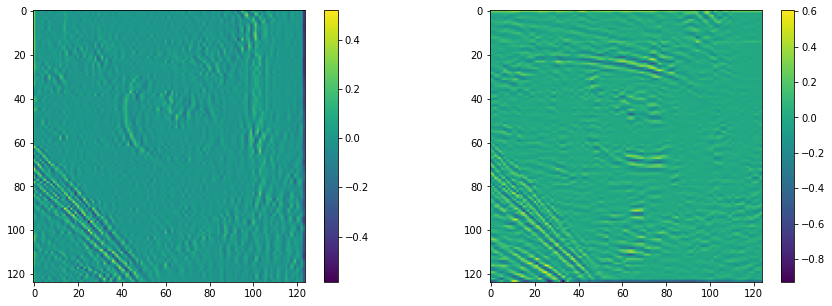

In [4]:
figure(figsize=(15,5))
subplot(121)
imshow(autodiff_jacobian_int[...,0][2:-2,2:-2] - numdiff_jacobian_int[...,0][2:-2,2:-2]); colorbar()
subplot(122)
imshow(autodiff_jacobian_int[...,1][2:-2,2:-2] - numdiff_jacobian_int[...,1][2:-2,2:-2]); colorbar()

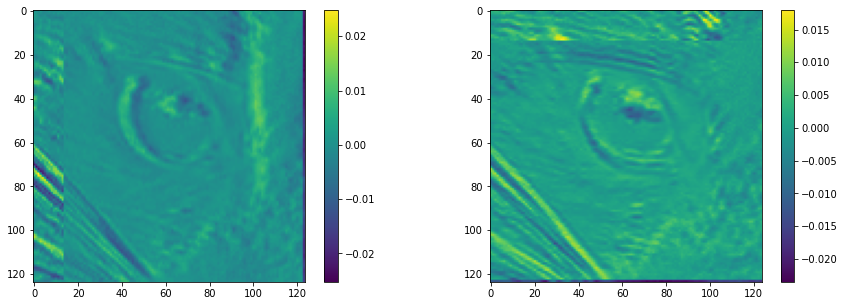

In [5]:
figure(figsize=(15,5))
subplot(121)
imshow(autodiff_jacobian_half[...,0][2:-2,2:-2] - numdiff_jacobian_half[...,0][2:-2,2:-2]); colorbar()
subplot(122)
imshow(autodiff_jacobian_half[...,1][2:-2,2:-2] - numdiff_jacobian_half[...,1][2:-2,2:-2]); colorbar()